# Introduction

Nesse projeto, você será desafiado por uma empresa de seguros de saúde a detectar os clientes que são mais propensos a comprar um segundo seguro, mas dessa vez, um seguro de automóvel. Sua missão é **calcular a propensão de compra de cada cliente da base e retornar para o time de negócio, uma lista priorizada, começando pelo cliente mais propenso até o menor propenso**

# 1. Imports and SQL Connect

In [121]:
# Data Processing
import pandas as pd
#import pandas.io.sql as psql
import psycopg2 as pg
import numpy as np
import pickle

# Visualization
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib
import seaborn as sns
from scipy.stats import chi2_contingency
import scikitplot as skplt
from IPython.display import Image
from IPython.core.display import HTML

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

# API
import requests
import json

## 1.0 Function

In [114]:
def save_model(path, filename, model):

    path_ = str(Path.cwd().parents[0])
    path_ = path_ + path + '/' + filename
    pickle.dump(model, open(path_, 'wb'))

    return None

In [134]:
def recall_at_k(data, score, sample_perc = 0.5):
    
    # transform sample_perc into k-row value
    k = int(len(data) * sample_perc) # get corresponding row of the dataset

    # sort list by propensity score value
    data = data.sort_values(score, ascending = False)

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1 # ranking number starts at 1

    # create recall_at_k column
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    # return recall value at k row
    return data.loc[k, 'recall_at_k']

In [135]:
def precision_at_k(data, score, sample_perc = 0.5):
    
    # transform sample_perc into k-row value
    k = int(len(data) * sample_perc) # get corresponding row of the dataset

    # sort list by propensity score value
    data = data.sort_values(score, ascending = False)

    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1 # ranking number starts at 1

    # create precision_at_k column
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    # return precision value at k row
    return data.loc[k, 'precision_at_k']


In [2]:
def frequency_table(data: pd.DataFrame):
    '''
    --> Show a bivariate table of proportion about independent and target variables
    
    :data: DataFrame to visualize proportion table
    '''
    df = pd.DataFrame(round(data.value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
    df['Count'] = data.value_counts().values
    display(df)

In [3]:
def pg_query(query_schema):
    '''
    --> Queries the database
    
    :param query_schema: Specific schema to be query
    '''
    conn = pg.connect(database=database, user=username, password=password, host=host, port=port)
    cursor = conn.cursor()
    cursor.execute(query_schema)
    record = cursor.fetchall()
    cursor.close()
    conn.close()
    print(record)

In [4]:
def graph_info(title: str, x_lable= None):
    '''
    --> Show the title of a graph
    
    :param title: Title to display
    :param x_lable: X lable description
    '''
    plt.title(title, loc='left', fontsize=18)
    plt.xlabel(x_lable)
    plt.show()

In [5]:
 def box_hist_plot(variable = str):
    '''
    --> Bivariate analysis of variables and response target
    
    :param variable: Variable to be compare with response
    '''
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df4, x='response', y=variable )
    plt.title(f'{variable} X Response', loc='left', fontsize=18)

    plt.subplot(1, 2, 2)
    sns.histplot(df4, x=variable, hue='response')
    plt.show()

In [6]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [7]:
jupyter_settings() 

Populating the interactive namespace from numpy and matplotlib


In [8]:
 def cramer_v(x, y):
    '''
    --> Categorical variable correlation calc
    
    :param x: column 1
    :param y: column 2
    
    return cramer v correlation
    '''
    #cm: crosstab matrix apply to categoricals variables  
    #n: sum of crosstab matrix 
    #r: rows
    #k: columns
    cm = np.array(pd.crosstab(x, y))
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))

    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2_corr / n) / (min(kcorr - 1, rcorr - 1)))

In [9]:
def precision_at_k( data, k=2000, model_name=str):
    '''
    --> Calculate the model precision at the k position in ranking
    
    :param dataframe data: The data with response and probabilities calculated
    :param int k: The k ranking position to return the precision
    :param str model_name: The name of Machine Learning model that calculate the probabilites
    
    print The precison at k ranking position
    '''
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    print(f"Model: {model_name} \nRanking Position: {k} \nPrecison: {round(data.loc[k, 'precision_at_k'], 2)}")

In [10]:
def recall_at_k( data, k=2000, model_name=str):
    '''
    --> Calculate the model recall at the k ranking position
    
    :param dataframe data: The data with response and probabilities calculated
    :param int k: The k ranking position to return the recall 
    :param str model_name: The name of Machine Learning model that calculate the probabilites
    
    return The recall at k ranking position
    '''
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    print(f"Model: {model_name} \nRanking Position: {k} \nRecall: {round(data.loc[k, 'recall_at_k'], 2)}") 

## 1.1 SQL Connect

In [11]:
import psycopg2 as pg
import pandas as pd 

In [12]:
# Credentials

host = "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com"
port = 5432
database = "comunidadedsdb"
username = "member"
password  = "cdspa"

In [13]:
conn = pg.connect ( user=username, 
                    password=password, 
                    host=host,
                    port=port,
                    database=database )

In [14]:
cursor = conn.cursor()

query_schema = """
              SELECT nspname
              FROM pg_catalog.pg_namespace    
"""

cursor.execute( query_schema )

record = cursor.fetchall()
cursor.close()


### 1.1.1 Table Query

In [15]:
cursor = conn.cursor()
query_table ="""
    SELECT tablename
    FROM pg_tables
    WHERE schemaname='pa004'
"""

cursor.execute( query_table )
record = cursor.fetchall()

print(record)

cursor.close()
conn.close()

[('users',), ('vehicle',), ('insurance',)]


### 1.1.2 Collect Data Using Pandas

In [16]:
conn = pg.connect(database=database, user=username, password=password, host=host, port=port)
query_schema = '''
SELECT *
FROM pa004.users u LEFT JOIN pa004.vehicle v on (u.id = v.id)
                  LEFT JOIN pa004.insurance i on (u.id = i.id)
'''
df_raw = pd.read_sql(query_schema, conn)
conn.close()

In [17]:
df_raw.columns 

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'id',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'id',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [18]:
df_raw = df_raw.iloc[:, [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13]] 

In [19]:
df_raw.head() 

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


In [20]:
df_raw.to_csv('datas/df_raw.csv', index=False) 

In [21]:
data_raw_fields = {'id': 'Unique ID for the customer',
                'gender': 'Gender of the customer',
                'age': 'Age of the customer',
                'driving_license': '0 : Customer does not have DL, 1 : Customer already has DL',
                'region_code': 'Unique code for the region of the customer',
                'previously_insured': '1 : Customer already has Vehicle Insurance, 0 : Customer doesn"t have Vehicle Insurance',
                'vehicle_age': 'Age of the Vehicle',
                'vehicle_damage': '1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn"t get his/her vehicle damaged in the past.',
                'annual_premium': 'The amount customer needs to pay as premium in the year',
                'policy_sales_hannel': 'Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.',
                'vintage': 'Number of Days, Customer has been associated with the company',
                'response': '1 : Customer is interested, 0 : Customer is not interested'}

data_raw_fields

{'id': 'Unique ID for the customer',
 'gender': 'Gender of the customer',
 'age': 'Age of the customer',
 'driving_license': '0 : Customer does not have DL, 1 : Customer already has DL',
 'region_code': 'Unique code for the region of the customer',
 'previously_insured': '1 : Customer already has Vehicle Insurance, 0 : Customer doesn"t have Vehicle Insurance',
 'vehicle_age': 'Age of the Vehicle',
 'vehicle_damage': '1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn"t get his/her vehicle damaged in the past.',
 'annual_premium': 'The amount customer needs to pay as premium in the year',
 'policy_sales_hannel': 'Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.',
 'vintage': 'Number of Days, Customer has been associated with the company',
 'response': '1 : Customer is interested, 0 : Customer is not interested'}

# 2. Data Description

In [22]:
df1 = pd.read_csv('datas/df_raw.csv') 

In [23]:
df1.head() 

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 2.1 Dimension

In [24]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 381109
Number of columns: 12


## 2.2 Data Types

In [25]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 2.3 Check NA

In [26]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 2.4 Descriptive Statistics


In [27]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 2.4.1 Numerical Attributes

In [28]:
aux = num_attributes.describe().T
aux['range'] = aux['max'] - aux['min']
aux['skewness'] = num_attributes.apply(lambda x: x.skew())
aux['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())
aux = aux.rename(columns={'50%': 'median'})
aux[['min', 'max', 'range', 'median', 'mean', 'std', 'skewness', 'kurtosis']]

,min,max,range,median,mean,std,skewness,kurtosis
id,1.0,381109.0,381108.0,190555.0,190555.000000,110016.836208,-8.071174e-18,-1.200000
age,20.0,85.0,65.0,36.0,38.822584,15.511611,6.725390e-01,-0.565655
region_code,0.0,52.0,52.0,28.0,26.388807,13.229888,-1.152664e-01,-0.867857
policy_sales_channel,1.0,163.0,162.0,133.0,112.034295,54.203995,-9.000081e-01,-0.970810
driving_license,0.0,1.0,1.0,1.0,0.997869,0.046110,-2.159518e+01,464.354302
previously_insured,0.0,1.0,1.0,0.0,0.458210,0.498251,1.677471e-01,-1.971871
annual_premium,2630.0,540165.0,537535.0,31669.0,30564.389581,17213.155057,1.766087e+00,34.004569
vintage,10.0,299.0,289.0,154.0,154.347397,83.671304,3.029517e-03,-1.200688
response,0.0,1.0,1.0,0.0,0.122563,0.327936,2.301906e+00,3.298788


**CONCLUSÃO**

IDADE - Temos mais consumidores novos 

Policy sales Channel - Temos muitos canais 

Driving Licnece - Muitos consumidores tem uma licença de direção

### 2.4.2 Categorical Attributes

In [29]:
frequency_table(cat_attributes) 

,gender,vehicle_age,vehicle_damage,%,Count
0,Male,1-2 Year,Yes,21.0,79533
1,Female,< 1 Year,No,17.0,66047
2,Male,< 1 Year,No,13.0,50543
3,Female,1-2 Year,Yes,13.0,48692
4,Male,1-2 Year,No,11.0,42791
5,Female,1-2 Year,No,8.0,29300
6,Female,< 1 Year,Yes,7.0,25274
7,Male,< 1 Year,Yes,6.0,22922
8,Male,> 2 Years,Yes,3.0,10293
9,Female,> 2 Years,Yes,1.0,5699


# 3.0 Feature Engineering

In [30]:
df3 = df1.copy()

## 3.1 Mind Map Hyphotesis

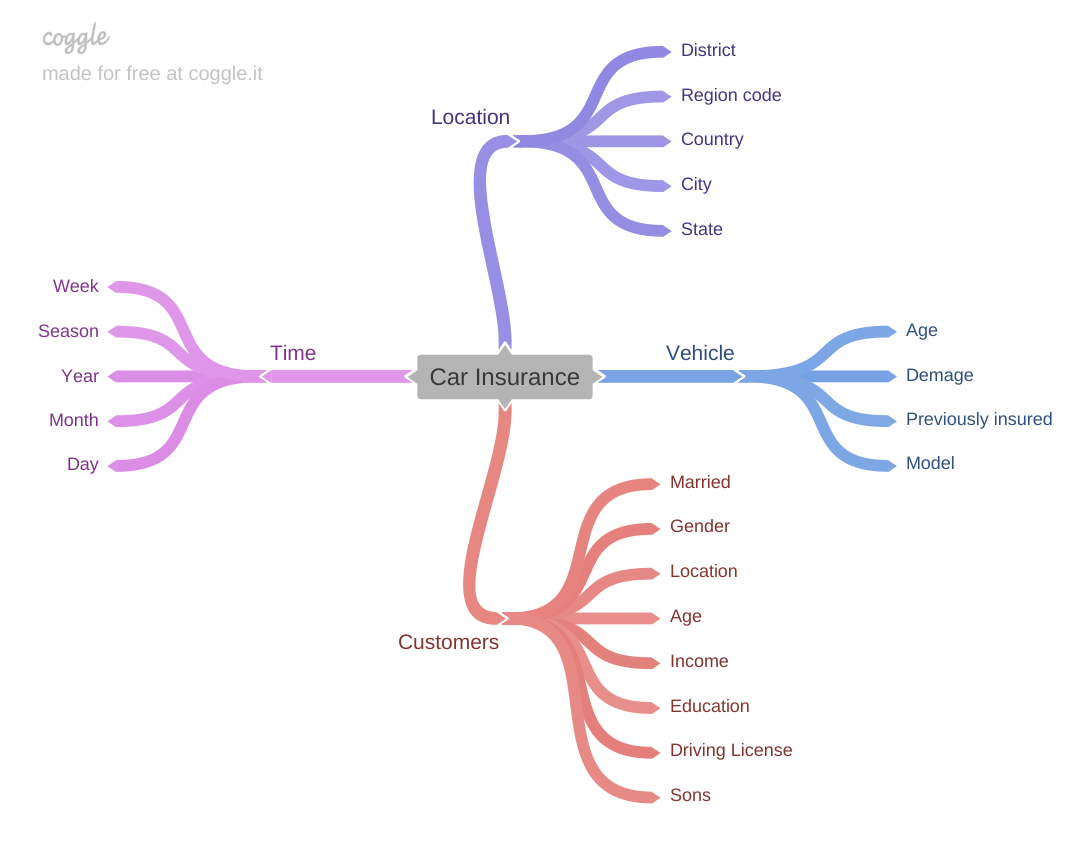

In [31]:
Image("datas/image.png")

In [32]:
## FEATURE ENGINERING 

'''
vehicle_age 
< 1 Year = bellow_1_year 
1-2 Year = between_1_2_year
> 2 Year = over_2_years
'''
df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 'below_1_year' if x == '< 1 Year' else 
                                  'between_1_2_year' if x == '1-2 Year' else 
                                  'over_2_years')

'''
vehicle_damage
Yes = 1
No = 0
'''
df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

## 3.2 Hiphotesis 

### 3.1.1 Vehicle Hyphotesis

H1. Novos Carros contratam mais seguros

H2. Carros danificados contratam mais seguros

### 3.1.2 Customers Hyphotesis
 

H1. As mulheres estão mais interessadas em seguros do que os homens
 
H2. Pessoas mais velhas estão mais interessadas em seguro automóvel

### 3.1.3  Location Hyphotesis


H1. A região tem influências no interesse pelo seguro de carro

## 3.2 Ouput Data

In [33]:
df3.to_csv('datas/df_feature_engineering.csv', index=False) 

## 3.3 EDA

In [34]:
df4 = pd.read_csv('datas/df_feature_engineering.csv')
num_attributes = df4.select_dtypes(['int64', 'float64'])
cat_attributes = df4.select_dtypes(['object'])

### 3.3.1 Categorical Analysis

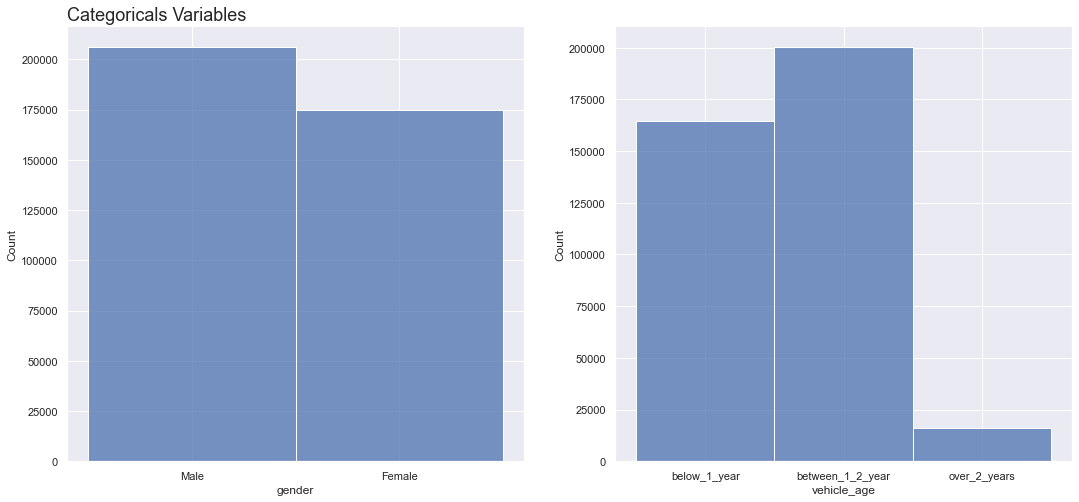

In [35]:
plt.figure(figsize=[18, 8])
plt.subplot(1, 2, 1)
sns.histplot(data=cat_attributes, x=cat_attributes.columns[0])
plt.title('Categoricals Variables', loc='left', fontsize=18)

plt.subplot(1, 2, 2)
sns.histplot(data=cat_attributes, x=cat_attributes.columns[1]);

### 3.3.2 Bivariate Analysis


#### H1. Novos Carros contratam mais seguros

Result: VERDADE

Conclusion: Carros com menos de 1 ano representam 63% dos que tem seguros 

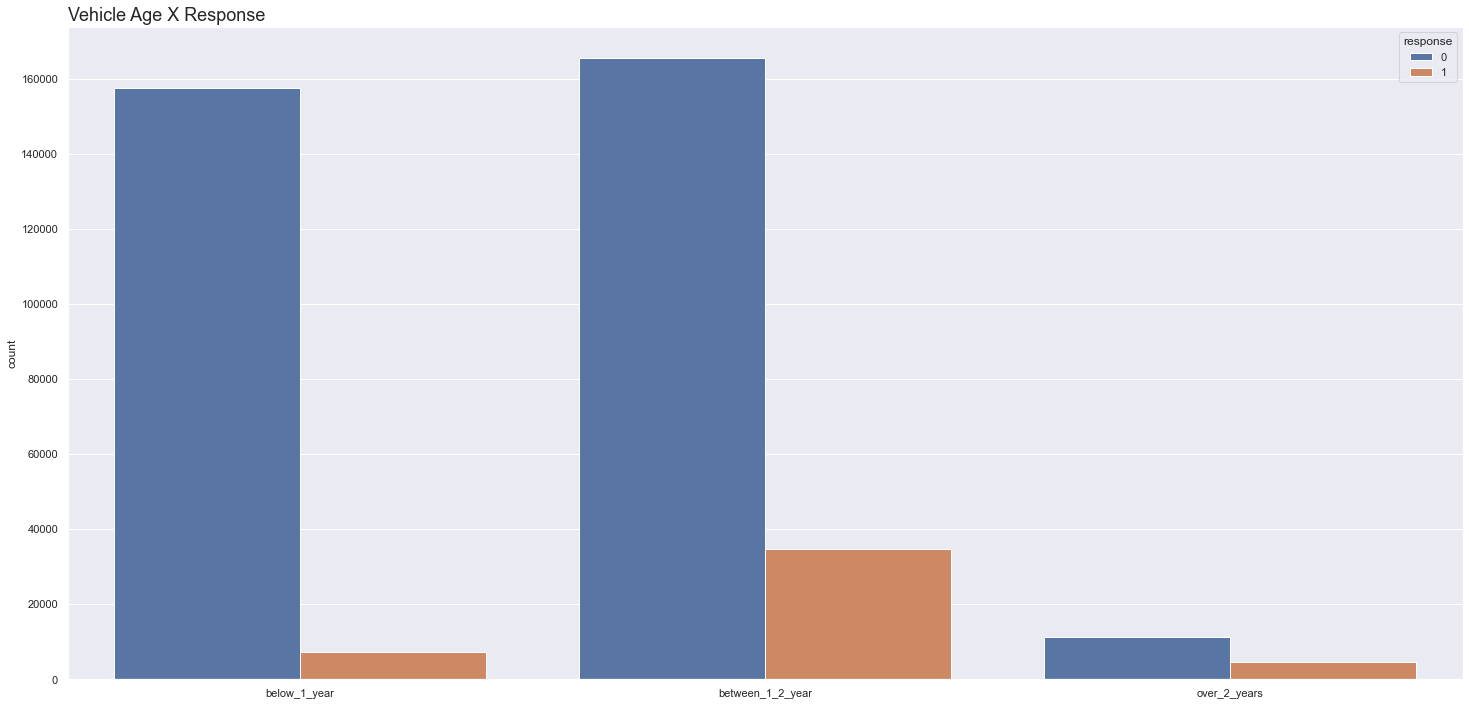

In [36]:
sns.countplot(data=df4, x='vehicle_age', hue='response')
graph_info('Vehicle Age X Response')

In [37]:
frequency_table(df4[['vehicle_age', 'response']]) 

,vehicle_age,response,%,Count
0,between_1_2_year,0,43.0,165510
1,below_1_year,0,41.0,157584
2,between_1_2_year,1,9.0,34806
3,over_2_years,0,3.0,11305
4,below_1_year,1,2.0,7202
5,over_2_years,1,1.0,4702


In [38]:
print('Previosly Insured and Vehicle Age')
round(df4[df4['previously_insured'] == 1]['vehicle_age'].value_counts(normalize=True) * 100)

Previosly Insured and Vehicle Age


below_1_year        63.0
between_1_2_year    37.0
over_2_years         0.0
Name: vehicle_age, dtype: float64

#### H2. Carros danificados contratam mais seguros

Result: Falso

Conclusion: Consumidores que tem um carro danificado são mais interessados no seguro, mas consumidores que já tem um seguro somente 6% tem carros danificados

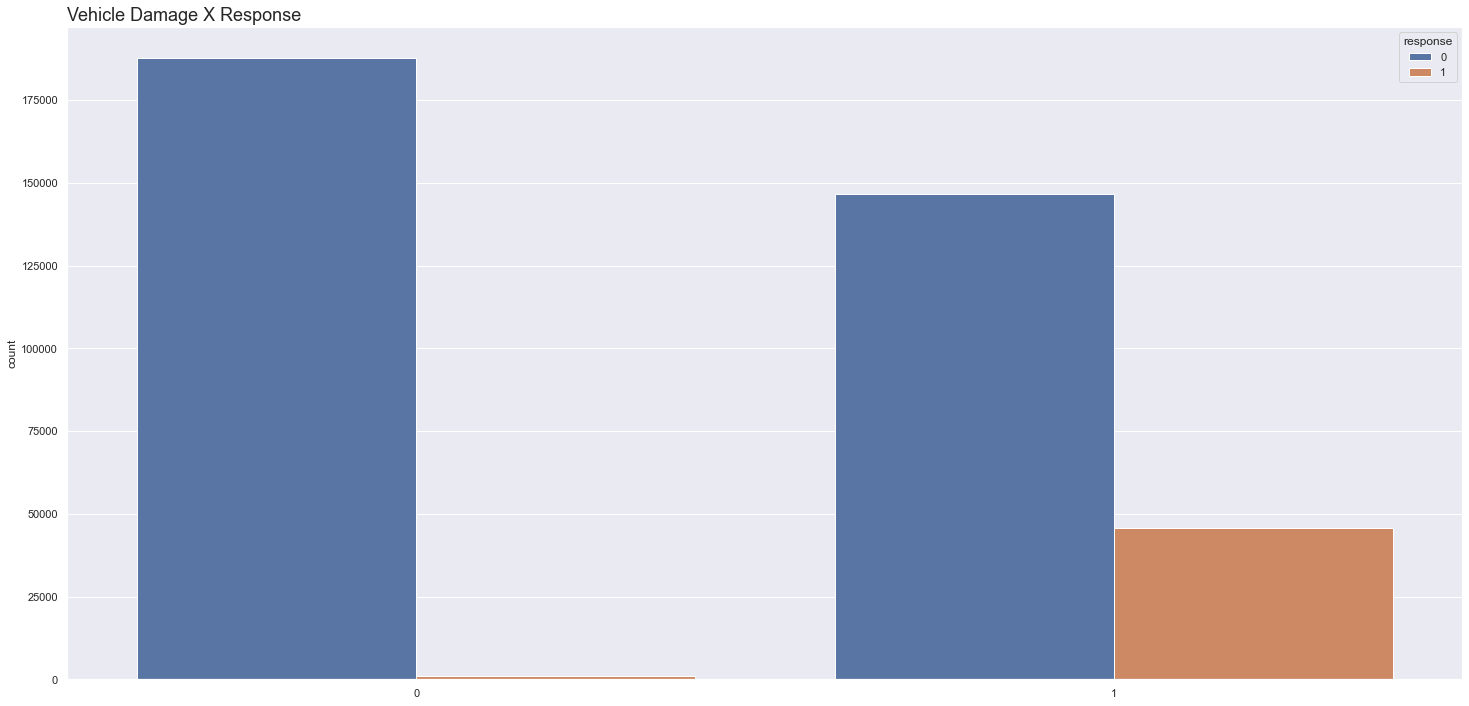

In [39]:
sns.countplot(data=df4, x='vehicle_damage', hue='response')
graph_info('Vehicle Damage X Response')

In [40]:
frequency_table(df4[df4['vehicle_damage'] == 1][['vehicle_damage', 'response']]) 

,vehicle_damage,response,%,Count
0,1,0,76.0,146685
1,1,1,24.0,45728


In [41]:
 print('Already Insured X Vehicle Damage')
round(df4[df4['previously_insured'] == 1]['vehicle_damage'].value_counts(normalize=True) * 100)

Already Insured X Vehicle Damage


0    94.0
1     6.0
Name: vehicle_damage, dtype: float64

#### H3.  As mulheres estão mais interessadas em seguros do que os homens


Result: Falso

Conclusion: Do grupo representado por interesados no seguro somente 6% são mulheres


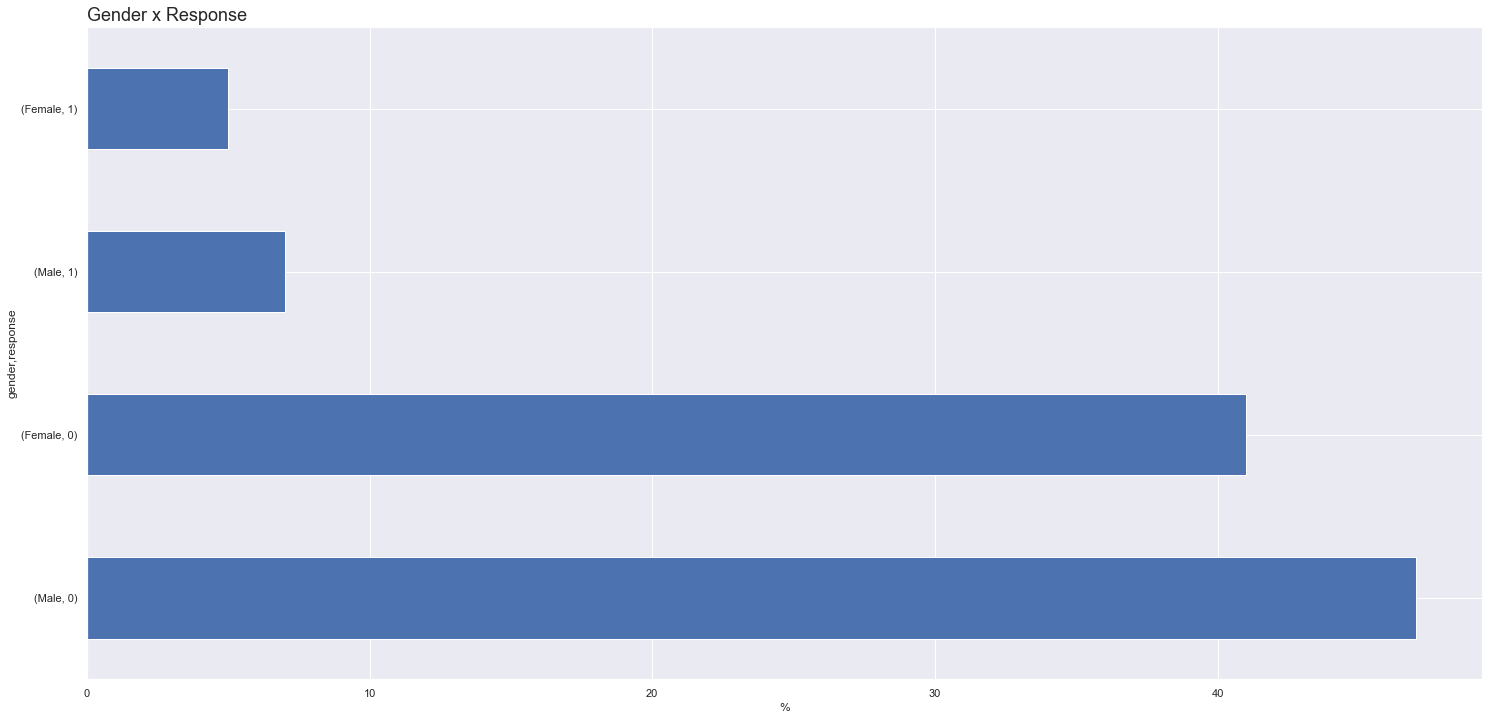

In [42]:
round(df4[['gender', 'response']].value_counts(normalize=True) * 100).plot(kind='barh')
graph_info('Gender x Response', x_lable='%')

In [43]:
print('Com seguros X Gender')
round(df4[df4['previously_insured'] == 1]['gender'].value_counts(normalize=True) * 100)

Com seguros X Gender


Female    50.0
Male      50.0
Name: gender, dtype: float64

In [44]:
print('Interessados nos Seguros X Gender')
round(df4[df4['response'] == 1]['gender'].value_counts(normalize=True) * 100)

Interessados nos Seguros X Gender


Male      61.0
Female    39.0
Name: gender, dtype: float64

In [45]:
print('Proporção de Gênero')
df4['gender'].value_counts(normalize=True)

Proporção de Gênero


Male      0.540761
Female    0.459239
Name: gender, dtype: float64

#### H4. Pessoas mais velhas estão mais interessadas em seguro automóvel

Result: Verdade]

Conclusion: As pssoas no grupo de interessadas são mais velhas


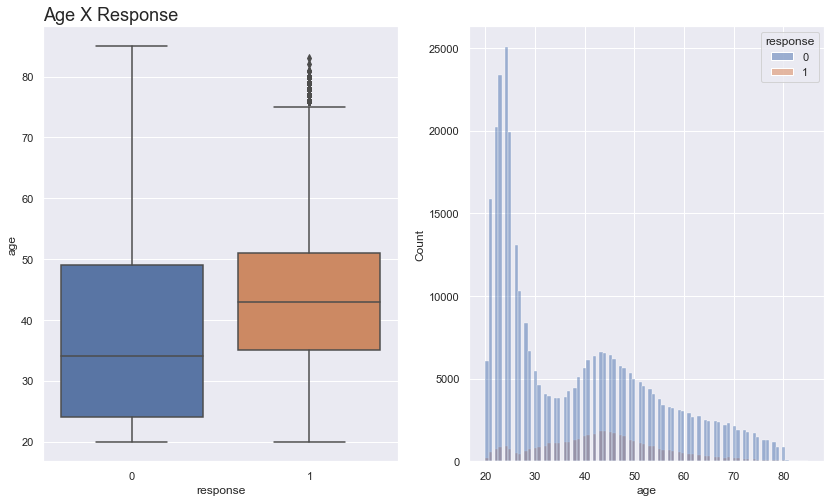

In [46]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
sns.boxplot(data=df4, x='response', y='age' )
plt.title('Age X Response', loc='left', fontsize=18)

plt.subplot(1, 2, 2)
sns.histplot(df4, x='age', hue='response')
plt.show()

In [47]:
print('Idade positiva para Cliente')
df4[df4['response'] == 1]['age'].describe()

Idade positiva para Cliente


count    46710.000000
mean        43.435560
std         12.168924
min         20.000000
25%         35.000000
50%         43.000000
75%         51.000000
max         83.000000
Name: age, dtype: float64

In [48]:
print('Idade negativa para Cliente')
df4[df4['response'] == 0]['age'].describe()

Idade negativa para Cliente


count    334399.000000
mean         38.178227
std          15.816052
min          20.000000
25%          24.000000
50%          34.000000
75%          49.000000
max          85.000000
Name: age, dtype: float64

In [49]:
 # Create a series with bined age
age_10 = pd.Series(pd.cut(df4['age'], bins=10), name='age_10')
# Aux variable with columns to look
aux = df4[['age', 'response']]
# Age bined age to aux
aux = pd.concat([aux, age_10], axis=1)
# Crosstab analysis
round(pd.crosstab(aux['age_10'], aux['response'], normalize='columns') * 100)

response,0,1
age_10,,
"(19.935, 26.5]",37.0,10.0
"(26.5, 33.0]",13.0,12.0
"(33.0, 39.5]",8.0,15.0
"(39.5, 46.0]",13.0,26.0
"(46.0, 52.5]",9.0,17.0
"(52.5, 59.0]",8.0,11.0
"(59.0, 65.5]",5.0,5.0
"(65.5, 72.0]",5.0,3.0
"(72.0, 78.5]",3.0,1.0


#### H5. A região tem influências no interesse pelo seguro de carro

Result: Falso

Conclusion: O desvio padrão dos dois grupos de resposta de consumidores é muito baixo o que indica que não existe correlação

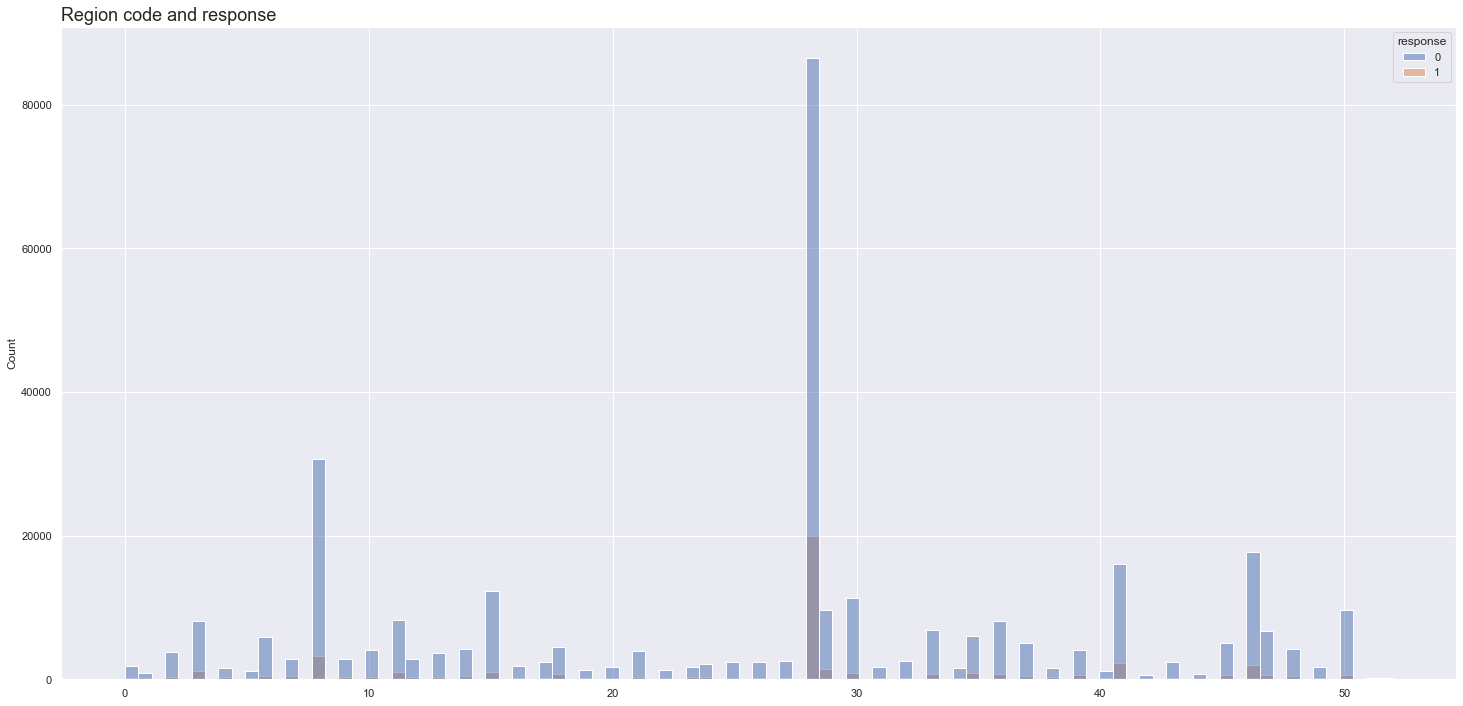

In [50]:
sns.histplot(x='region_code', data=df4, hue='response')
graph_info('Region code and response')

In [51]:
region_response = round(pd.crosstab(df4['region_code'], df4['response'], normalize='index') * 100)
region_response

response,0,1
region_code,,
0.0,91.0,9.0
1.0,89.0,11.0
2.0,93.0,7.0
3.0,87.0,13.0
4.0,84.0,16.0
5.0,88.0,12.0
6.0,93.0,7.0
7.0,87.0,13.0
8.0,90.0,10.0


In [52]:
region_response[0].describe() 

count    53.000000
mean     89.981132
std       3.405259
min      81.000000
25%      88.000000
50%      90.000000
75%      93.000000
max      96.000000
Name: 0, dtype: float64

In [53]:
region_response[1].describe() 

count    53.000000
mean     10.018868
std       3.405259
min       4.000000
25%       7.000000
50%      10.000000
75%      12.000000
max      19.000000
Name: 1, dtype: float64

### 3.3.3 Categoricals Variable

The gender don't seems to have an influence of response variable

In [54]:
frequency_table(df4[df4['vehicle_age'] == 'over_2_years'][['vehicle_age', 'response']]) 

,vehicle_age,response,%,Count
0,over_2_years,0,71.0,11305
1,over_2_years,1,29.0,4702


29% dos carros com idade superior a 2 anos tem interesse em seguros de carros 

### 3.3.4 Numericals Variables


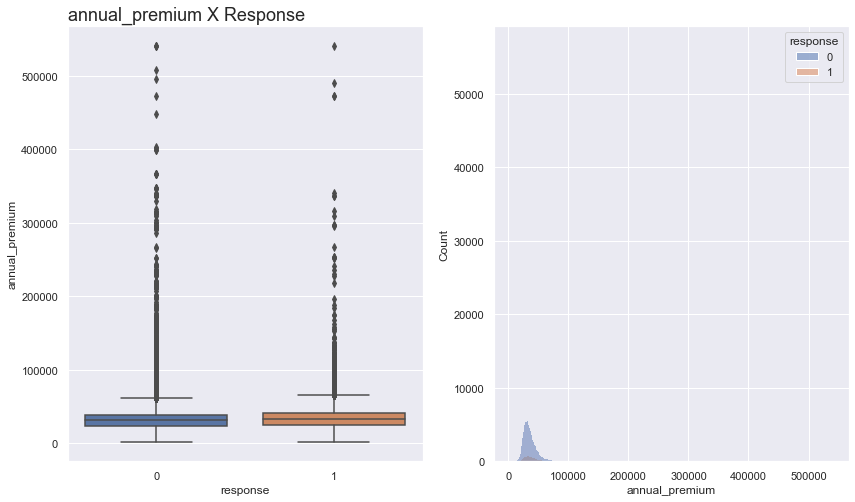

In [55]:
box_hist_plot('annual_premium') 

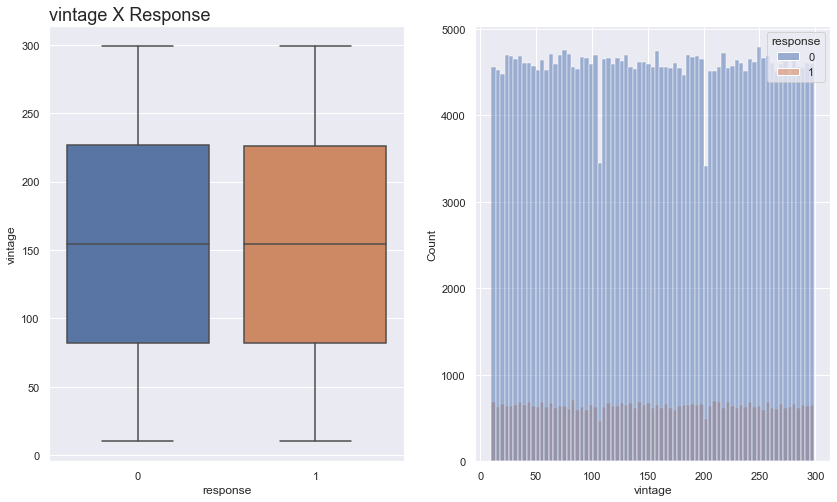

In [56]:
box_hist_plot('vintage') 

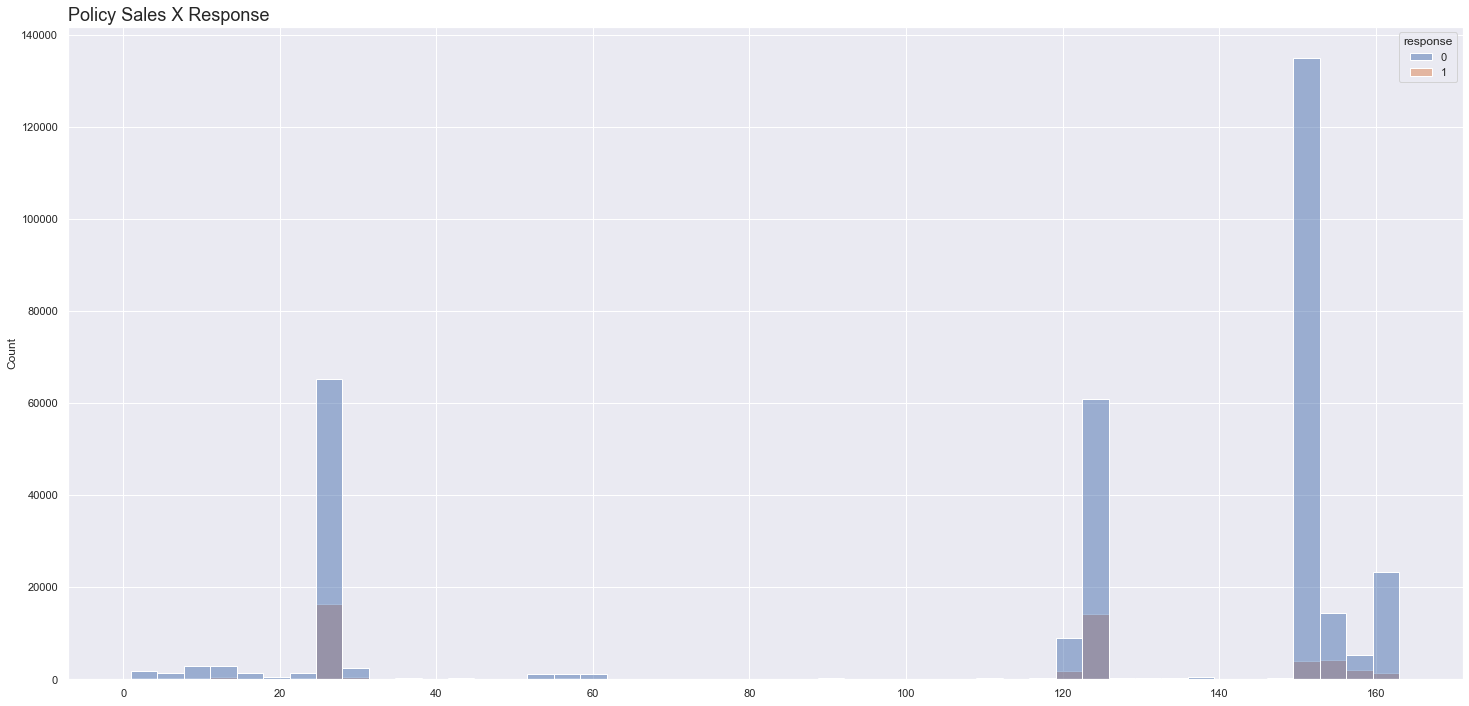

In [57]:
sns.histplot(data=df4, x='policy_sales_channel', hue='response')
graph_info('Policy Sales X Response')

### 3.3.5 Binary Variables


In [58]:
pd.DataFrame(round(df4[['driving_license', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'}) 

,driving_license,response,%
0,1,0,88.0
1,1,1,12.0
2,0,0,0.0
3,0,1,0.0


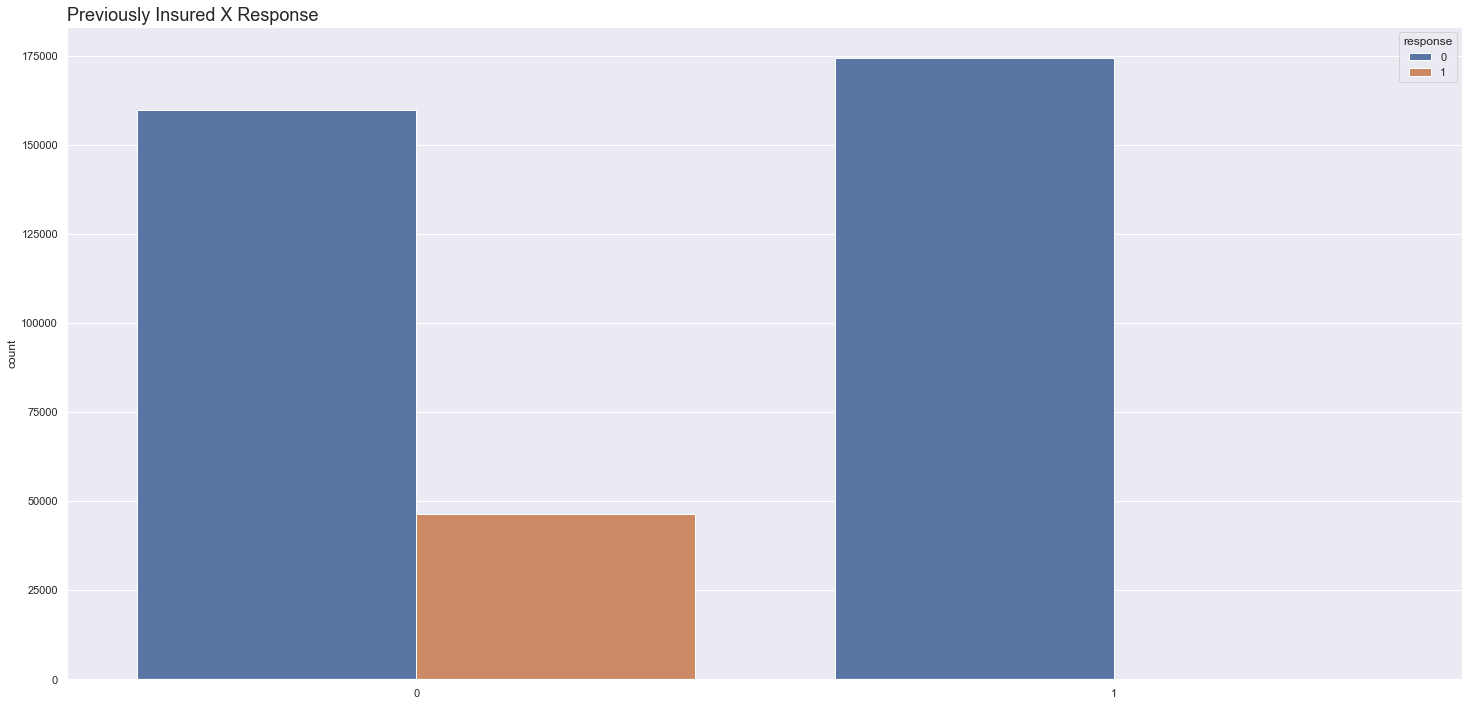

In [59]:
 sns.countplot(data=df4, x='previously_insured', hue='response')
graph_info('Previously Insured X Response')

In [60]:
frequency_table(df4[['previously_insured', 'response']]) 

,previously_insured,response,%,Count
0,1,0,46.0,174470
1,0,0,42.0,159929
2,0,1,12.0,46552
3,1,1,0.0,158


## 3.4 Multivariate Analysis

### Numerical

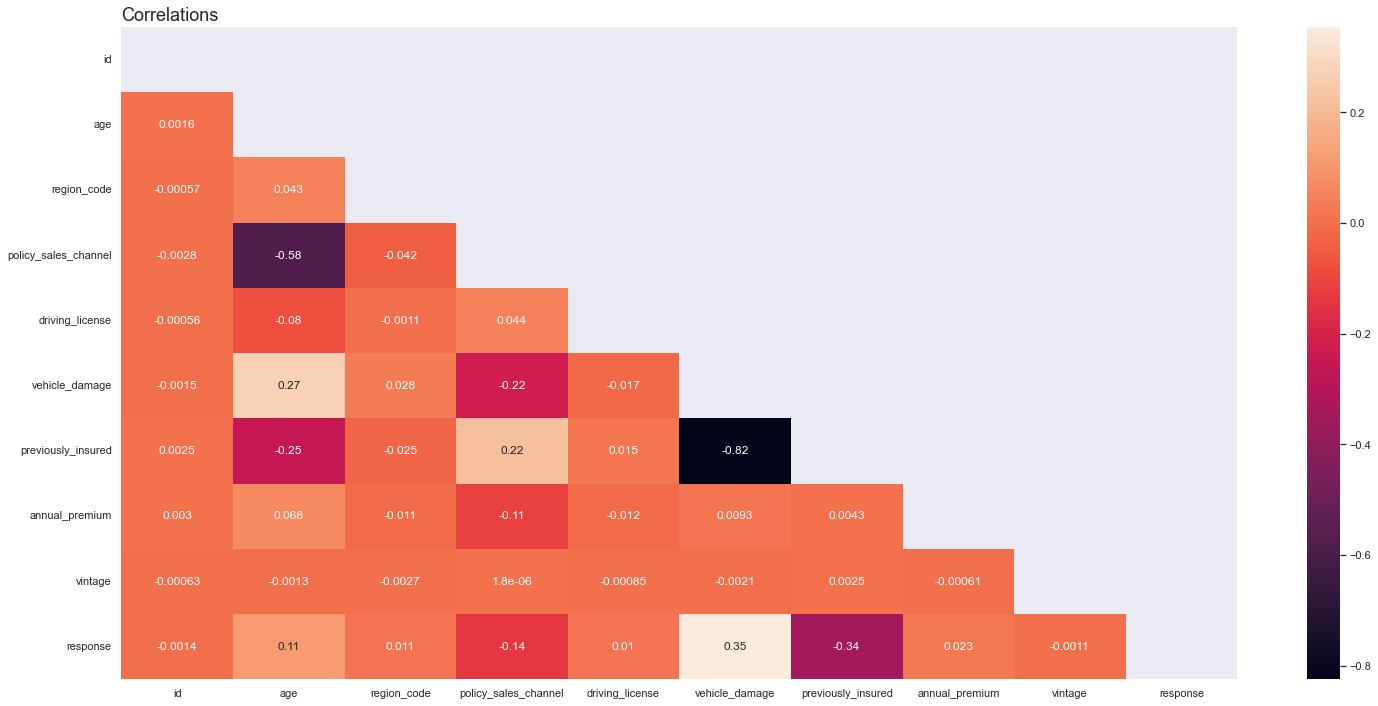

In [61]:
mask = np.zeros_like(df4.select_dtypes(['int64', 'float64']).corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df4.select_dtypes(['int64', 'float64']).corr(), annot=True, mask=mask)
graph_info('Correlations')

### Categorical

In [62]:
categoricals = df4[['gender', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 
                    'response']]

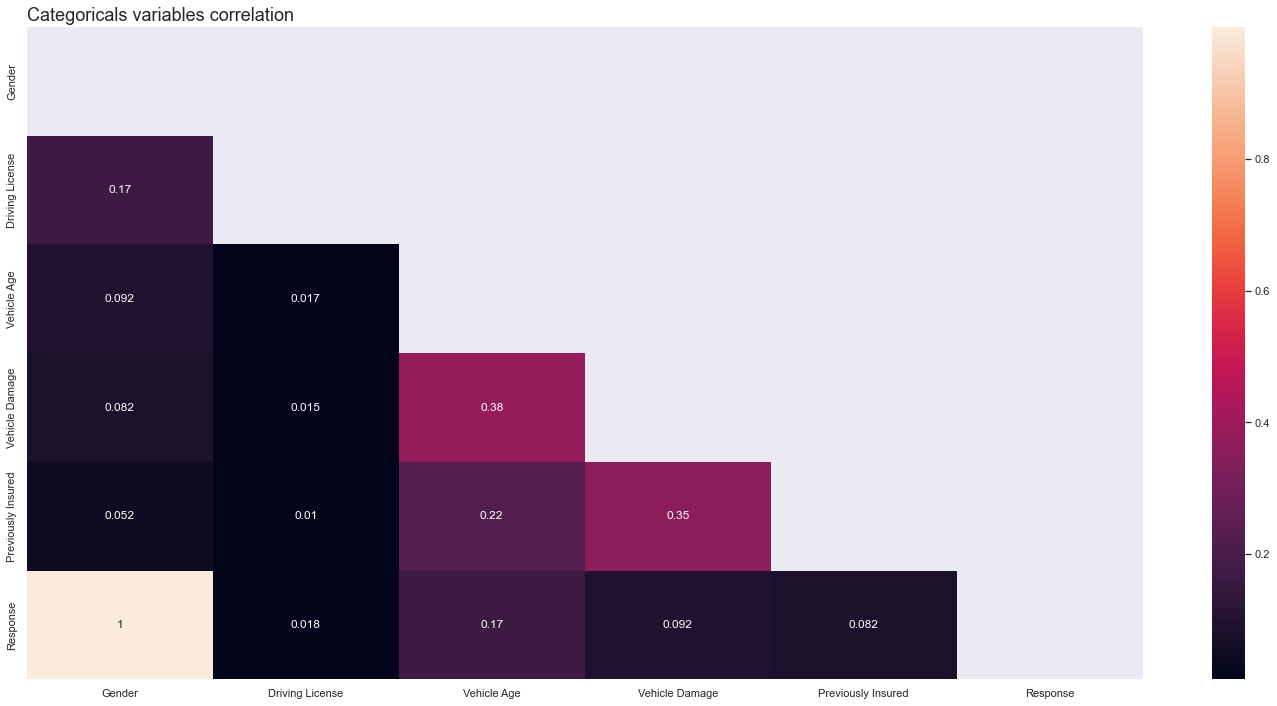

In [63]:
categoricals_1 = cramer_v(categoricals['gender'], categoricals['driving_license'])
categoricals_2 = cramer_v(categoricals['gender'], categoricals['vehicle_age'])
categoricals_3 = cramer_v(categoricals['gender'], categoricals['vehicle_damage'])
categoricals_4 = cramer_v(categoricals['gender'], categoricals['previously_insured'])
categoricals_5 = cramer_v(categoricals['gender'], categoricals['response'])
categoricals_6 = cramer_v(categoricals['gender'], categoricals['gender'])

categoricals_7 = cramer_v(categoricals['driving_license'], categoricals['driving_license'])
categoricals_8 = cramer_v(categoricals['driving_license'], categoricals['vehicle_age'])
categoricals_9 = cramer_v(categoricals['driving_license'], categoricals['vehicle_damage'])
categoricals_10 = cramer_v(categoricals['driving_license'], categoricals['previously_insured'])
categoricals_11 = cramer_v(categoricals['driving_license'], categoricals['response'])
categoricals_12 = cramer_v(categoricals['driving_license'], categoricals['gender'])

categoricals_13 = cramer_v(categoricals['vehicle_age'], categoricals['driving_license'])
categoricals_14 = cramer_v(categoricals['vehicle_age'], categoricals['vehicle_age'])
categoricals_15 = cramer_v(categoricals['vehicle_age'], categoricals['vehicle_damage'])
categoricals_16 = cramer_v(categoricals['vehicle_age'], categoricals['previously_insured'])
categoricals_17 = cramer_v(categoricals['vehicle_age'], categoricals['response'])
categoricals_18 = cramer_v(categoricals['vehicle_age'], categoricals['gender'])

categoricals_19 = cramer_v(categoricals['vehicle_damage'], categoricals['driving_license'])
categoricals_20 = cramer_v(categoricals['vehicle_damage'], categoricals['vehicle_age'])
categoricals_21 = cramer_v(categoricals['vehicle_damage'], categoricals['vehicle_damage'])
categoricals_22 = cramer_v(categoricals['vehicle_damage'], categoricals['previously_insured'])
categoricals_23 = cramer_v(categoricals['vehicle_damage'], categoricals['response'])
categoricals_24 = cramer_v(categoricals['vehicle_damage'], categoricals['gender'])

categoricals_25 = cramer_v(categoricals['previously_insured'], categoricals['driving_license'])
categoricals_26 = cramer_v(categoricals['previously_insured'], categoricals['vehicle_age'])
categoricals_27 = cramer_v(categoricals['previously_insured'], categoricals['vehicle_damage'])
categoricals_28 = cramer_v(categoricals['previously_insured'], categoricals['previously_insured'])
categoricals_29 = cramer_v(categoricals['previously_insured'], categoricals['response'])
categoricals_30 = cramer_v(categoricals['previously_insured'], categoricals['gender'])

categoricals_31 = cramer_v(categoricals['response'], categoricals['driving_license'])
categoricals_32 = cramer_v(categoricals['response'], categoricals['vehicle_age'])
categoricals_33 = cramer_v(categoricals['response'], categoricals['vehicle_damage'])
categoricals_34 = cramer_v(categoricals['response'], categoricals['previously_insured'])
categoricals_35 = cramer_v(categoricals['response'], categoricals['response'])
categoricals_36 = cramer_v(categoricals['response'], categoricals['gender'])


correlations = pd.DataFrame({
    'Gender': [categoricals_1, categoricals_2, categoricals_3, categoricals_4, categoricals_5, categoricals_6],
    'Driving License': [categoricals_7, categoricals_8, categoricals_9, categoricals_10, categoricals_11, 
                        categoricals_12],
    'Vehicle Age': [categoricals_13, categoricals_14, categoricals_15, categoricals_16, categoricals_17, 
                    categoricals_18],
    'Vehicle Damage': [categoricals_19, categoricals_20, categoricals_21, categoricals_22, categoricals_23, 
                       categoricals_24],
    'Previously Insured': [categoricals_25, categoricals_26, categoricals_27, categoricals_28, categoricals_29, 
                           categoricals_30],
    'Response': [categoricals_31, categoricals_32, categoricals_33, categoricals_34, categoricals_35, 
                 categoricals_36]
})
correlations = correlations.set_index(correlations.columns)

mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, annot=True, mask=mask)
graph_info('Categoricals variables correlation')

# 4.0 Data Preparation

In [69]:
# Read file
df8 = pd.read_csv('datas/df_feature_engineering.csv')

# Train (70%), Validation (20%) and Test (10%) data

# Test Data
df_test = df8.sample(frac=0.1, random_state=7).copy()

# Train and Validation
## Remove test data
df8 = df8.drop(df_test.index).copy()
## Split train and validation
X = df8.drop(columns='response').copy()
y = df8['response'].copy()
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20)

## 4.1 Encoder

Encoder
- Criar novas colunas no conjunto de dados


 Frequency Encoding
- Uma frequência de uma categoria relacionada à variável de resposta no conjunto de dados


Target Encoding
- Uma média de categorias no conjunto de dados


Weigthed Target Encoding
- Distância ou aproximação da média


Label Encoding
- Não existe uma ordem 

Order Encoding
- Quando exise ordem (pedido) nos dados

In [73]:
# simulates production environment

X = df8.drop('response', axis = 1) # real data does not contain response
y = df8['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size = 0.20, random_state = 9) # spit dataset between train and test

df = pd.concat([x_train, y_train], axis = 1)

# save validation datasets - they will be used to test the API later
# save_model('/data/interim', 'x_validation.pkl', x_validation)
# save_model('/data/interim', 'y_validation.pkl', y_validation)

### 4.1.1 Standardizartion

In [74]:
# annual_premium (we will not remove outliers now)

ss = pp.StandardScaler()

df['annual_premium'] = ss.fit_transform(df[['annual_premium']].values) # encoder receives an array

### 4.1.2 Rescaling

In [75]:
 # saves scaler to the same variable which will be used in the test
mms_age = pp.MinMaxScaler() 
mms_vintage = pp.MinMaxScaler()

# age
df['age'] = mms_age.fit_transform(df[['age']].values)

# vintage
df['vintage'] = mms_vintage.fit_transform(df[['vintage']].values)

### 4.1.3 Enconding

In [76]:
# gender
target_encode_gender = df.groupby('gender')['response'].mean()
df.loc[:,'gender'] = df['gender'].map(target_encode_gender)

# region_code - Frequency Encoding | Target Encoding (we choose this) | Weigthed Target Encoding
target_encode_region_code = df.groupby('region_code')['response'].mean()
df.loc[:,'region_code'] = df['region_code'].map(target_encode_region_code) # replace all values within policy_sales_channel column with encoded values

# vehicle_age - One Hot Encoding (we choose this) | Order Encoding
df = pd.get_dummies(df, prefix = 'vehicle_age', columns = ['vehicle_age'])

# policy_sales_channel - Target Encoding | Frequency Encoding (we choose this)
# Frequency Encoding gives more weight to more frequent values of the categorical attribute
fe_policy_sales_channel = df.groupby('policy_sales_channel').size() / len(df)
df.loc[:,'policy_sales_channel'] = df['policy_sales_channel'].map(fe_policy_sales_channel) # replace all values within policy_sales_channel column with encoded values

### 4.1.4 Validantion Preparation

In [77]:
# applies same training encoders to testing (validation, val) data

# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_validation.loc[:, 'vehicle_age'] = pd.get_dummies(x_validation, prefix = 'vehicle_age', columns = ['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

# 5. Feature Selection

## 5.1 Features Importance

In [78]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators = 250, random_state = 0, n_jobs = -2) # n_jobs will not use all cores

# data preparation
x_train_n = df.drop(['id', 'response'], axis = 1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-2, random_state=0)

Feature Ranking:
                        feature  importance
0                       vintage    0.271645
0                annual_premium    0.243136
0                           age    0.167728
0                   region_code    0.106322
0                vehicle_damage    0.066830
0          policy_sales_channel    0.058646
0            previously_insured    0.056826
0      vehicle_age_below_1_year    0.014853
0  vehicle_age_between_1_2_year    0.006307
0                        gender    0.005164
0      vehicle_age_over_2_years    0.002084
0               driving_license    0.000459


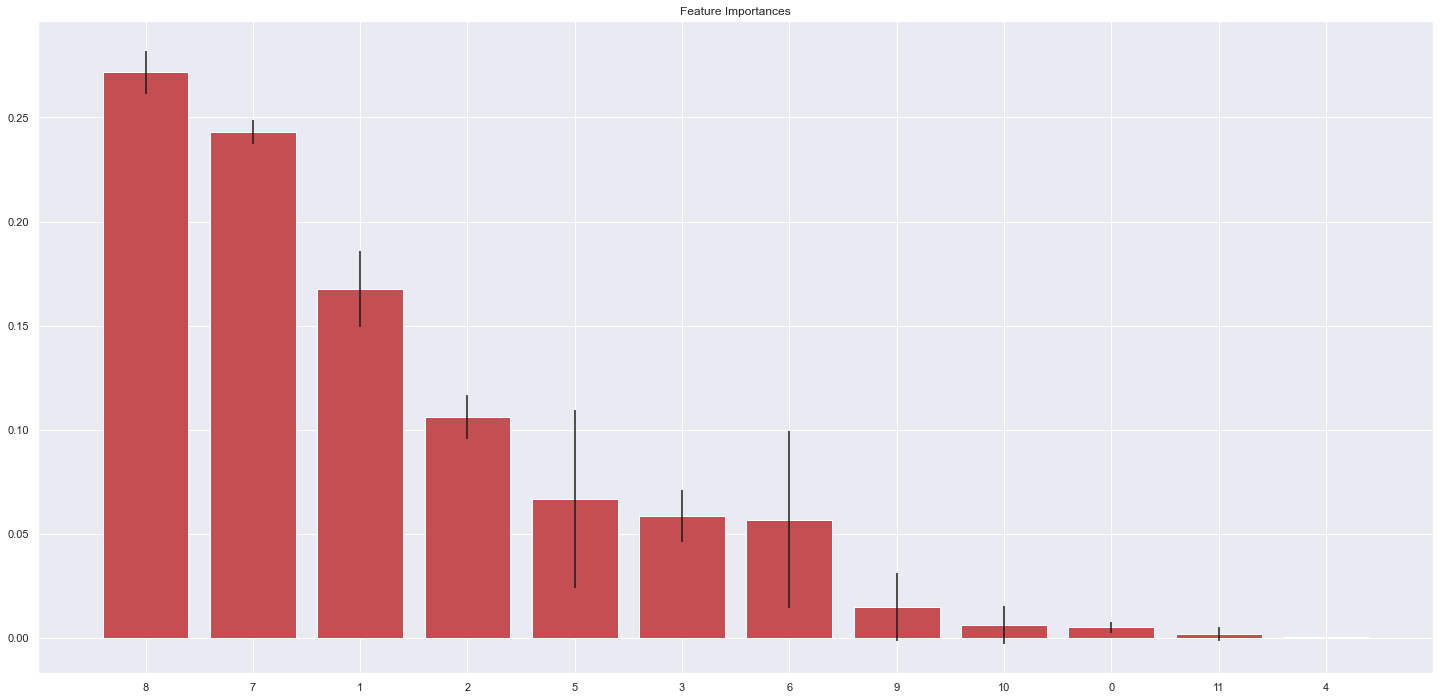

In [80]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print('Feature Ranking:')
data = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index = [0])
    data = pd.concat([data, aux], axis = 0)

print(data.sort_values('importance', ascending = False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'r', yerr = std[indices], align = 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 6. Machine Learning

In [81]:
 # arbitrary selection
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

In [82]:
 # using only the selected features to train and test (validation) the model
x_train = df[cols_selected]
x_val = x_validation[cols_selected]

## 6.1 KNN 

" ' O que este gráfico diz? \nSe eu fizer a oferta para 40% da lista ordenada, encontrarei ~85% de interessados \u200b\u200b(com 07 vizinhos) \nnisso significa que o modelo KNN deixou os interessados no final da lista\u200b nmore KNN Neighbors = vou encontrar mais pessoas interessadas'\n"

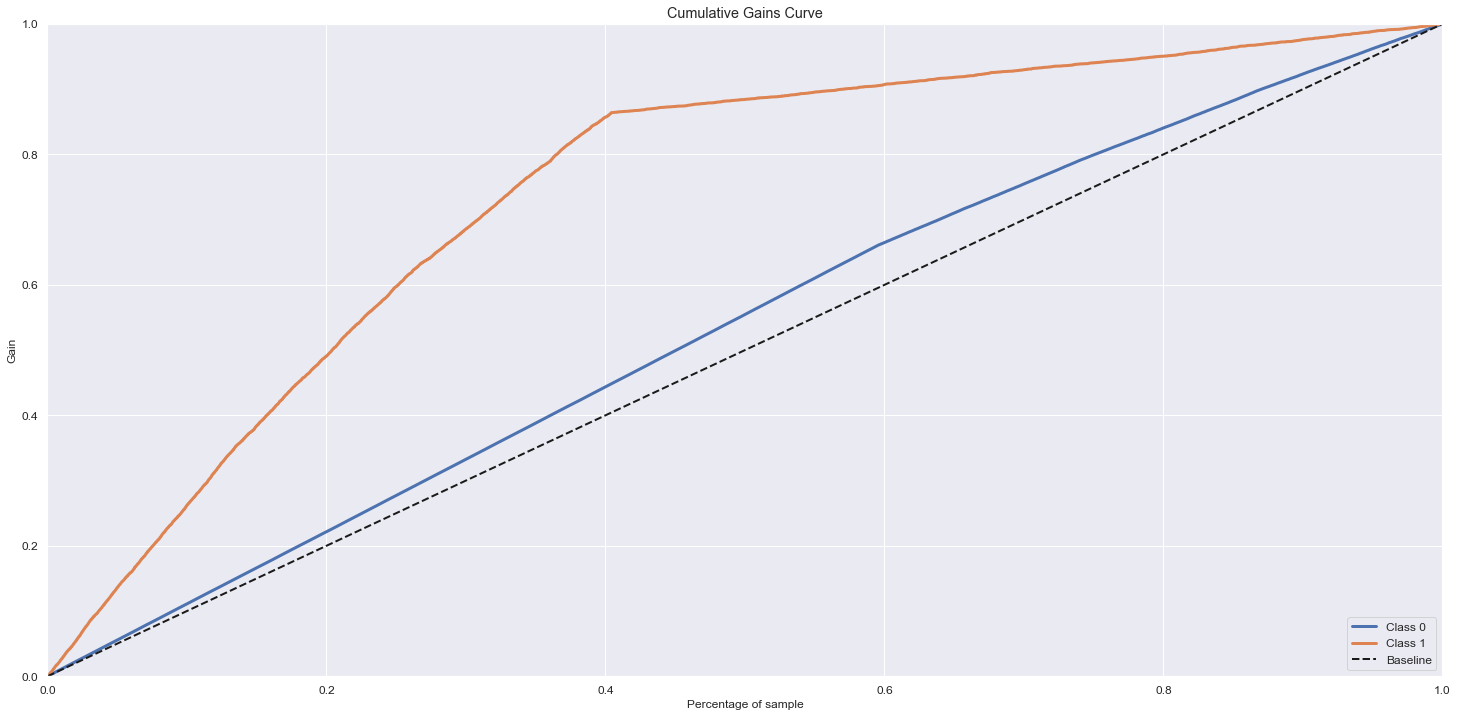

In [93]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_knn = knn_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn);

""" ' O que este gráfico diz? 
Se eu fizer a oferta para 40% da lista ordenada, encontrarei ~85% de interessados ​​(com 07 vizinhos) 
nisso significa que o modelo KNN deixou os interessados no final da lista​ nmore KNN Neighbors = vou encontrar mais pessoas interessadas'
"""

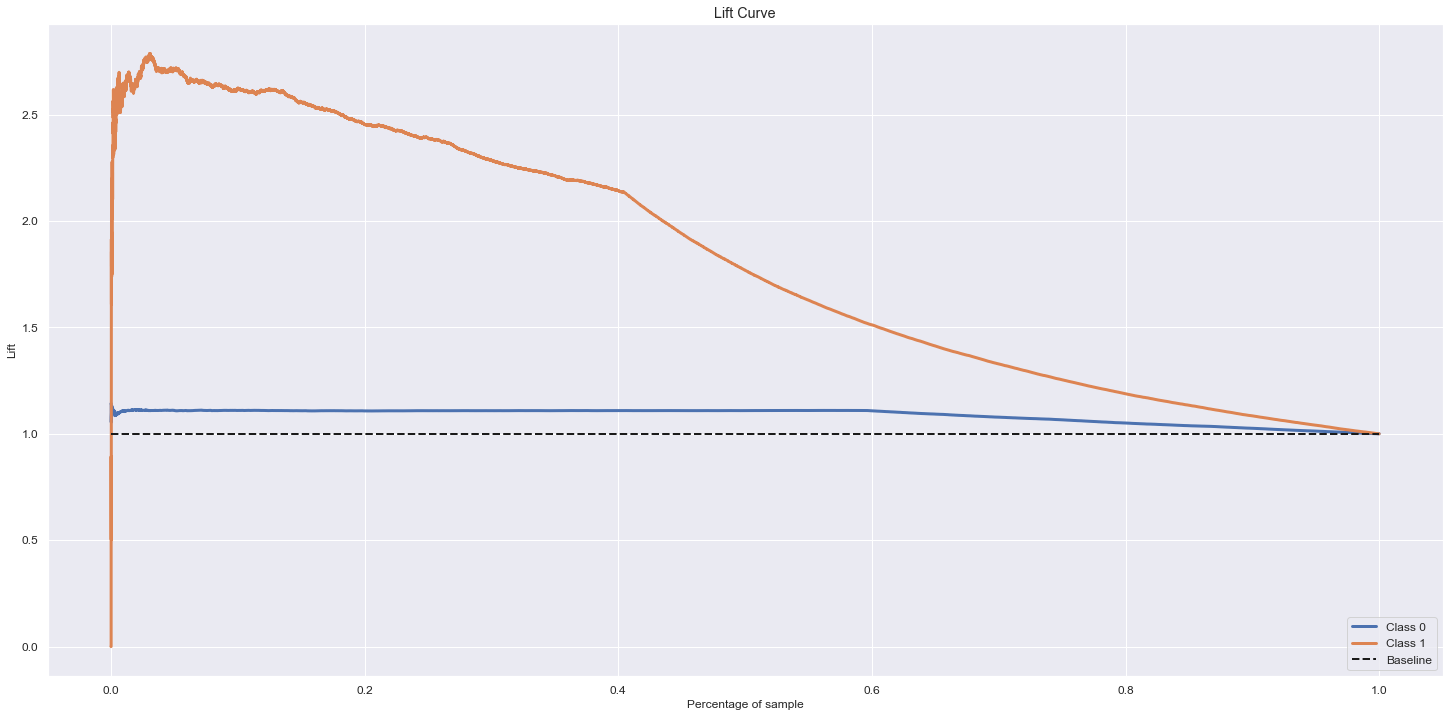

In [95]:
# Lift Curve

skplt.metrics.plot_lift_curve(y_validation, yhat_knn); 

## 6.2 Linear Regression

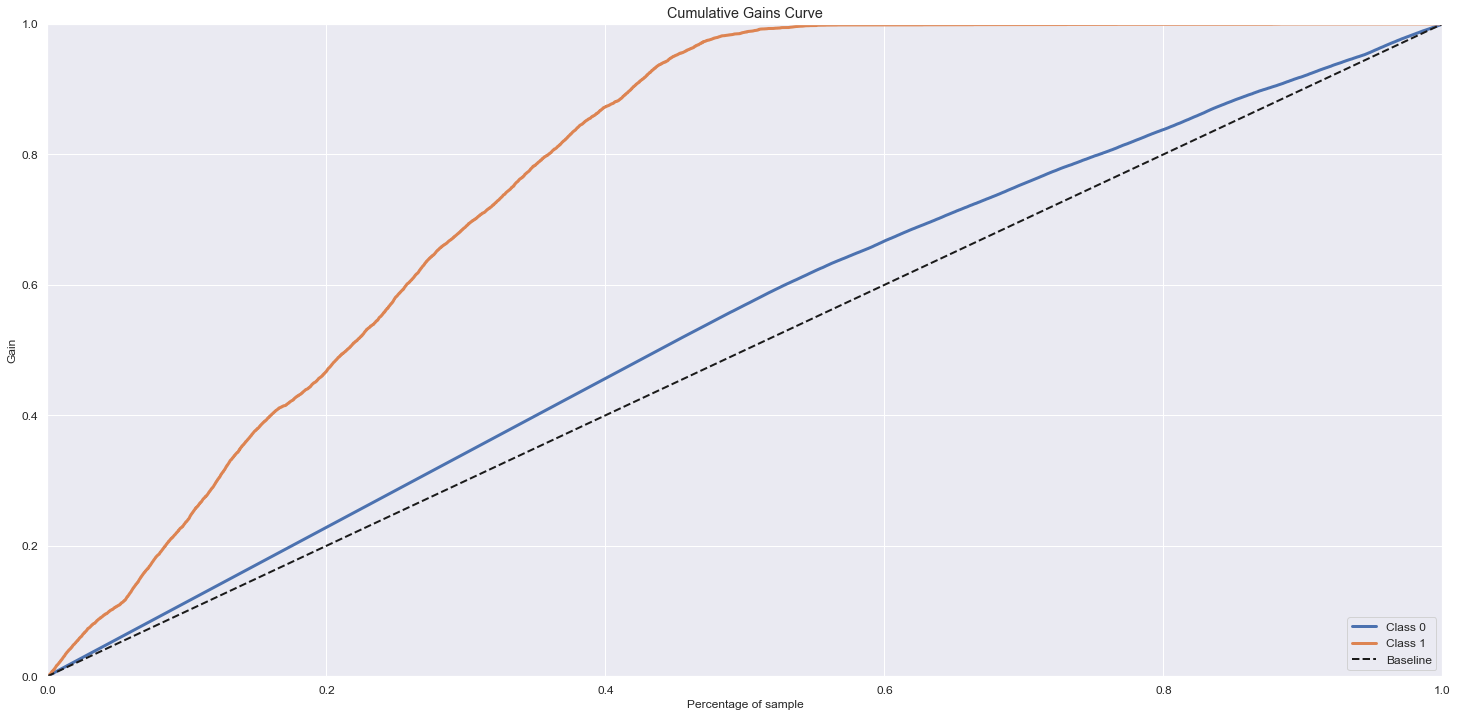

In [96]:
# model definition
lr_model = lm.LogisticRegression(random_state = 42)

# model training
lr_model.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_lr = lr_model.predict_proba(x_val)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr);

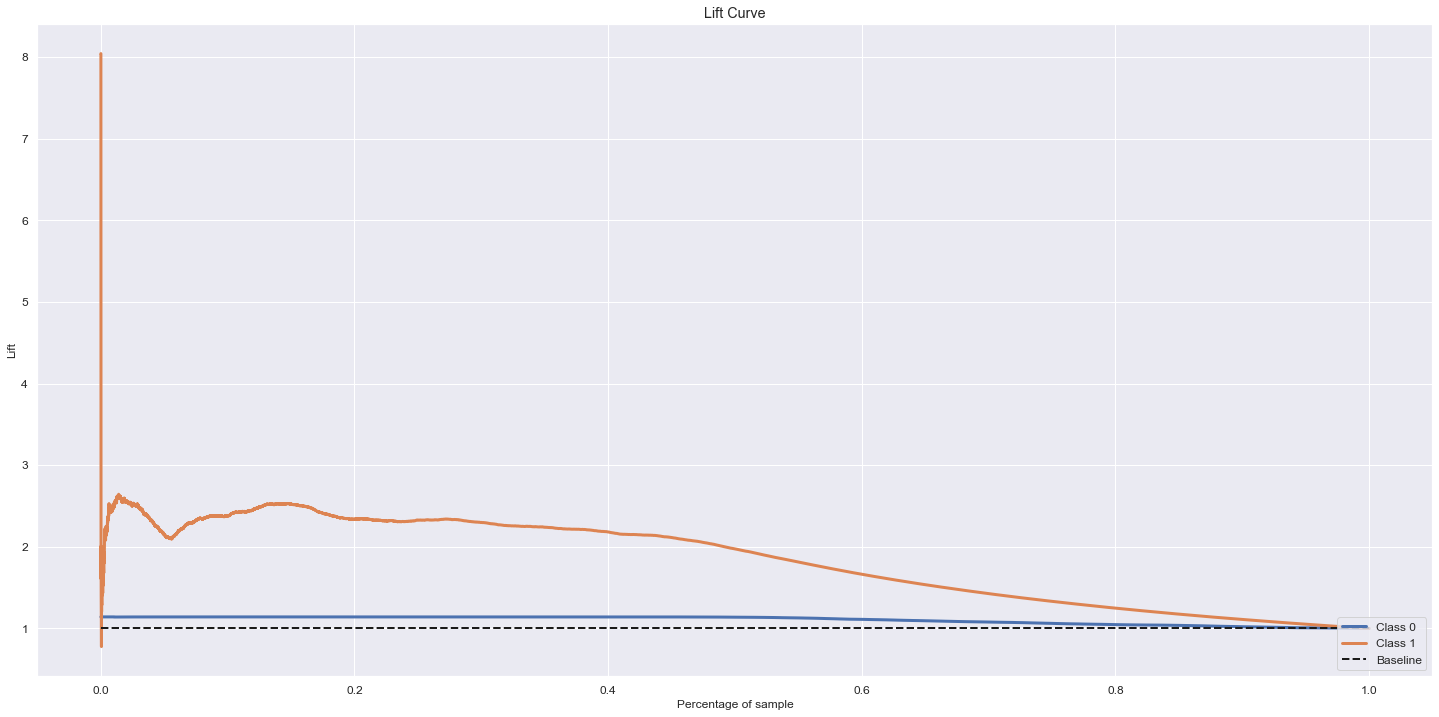

In [97]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lr);

## 6.3 Extra Trees

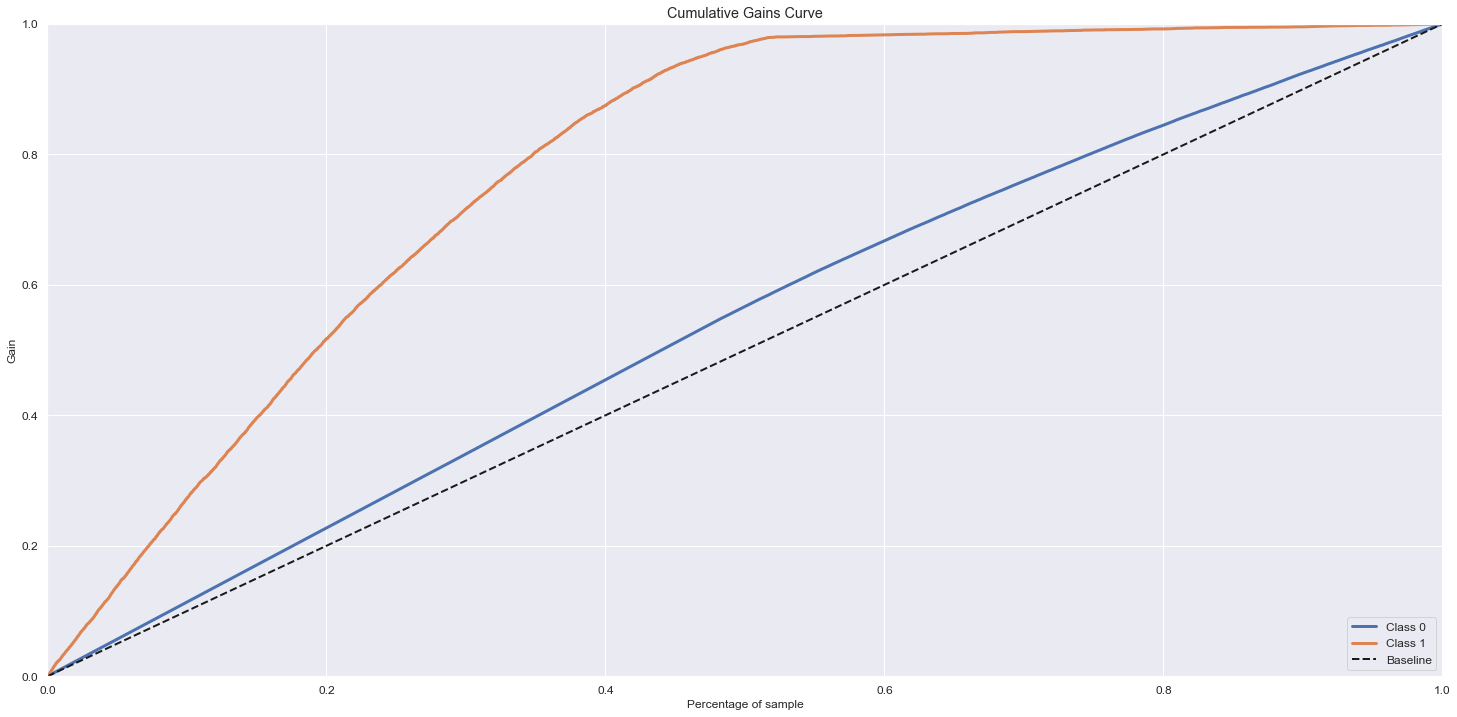

In [98]:
 # model definition
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)

# model training
et.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_et = et.predict_proba(x_val)

skplt.metrics.plot_cumulative_gain(y_validation, yhat_et);

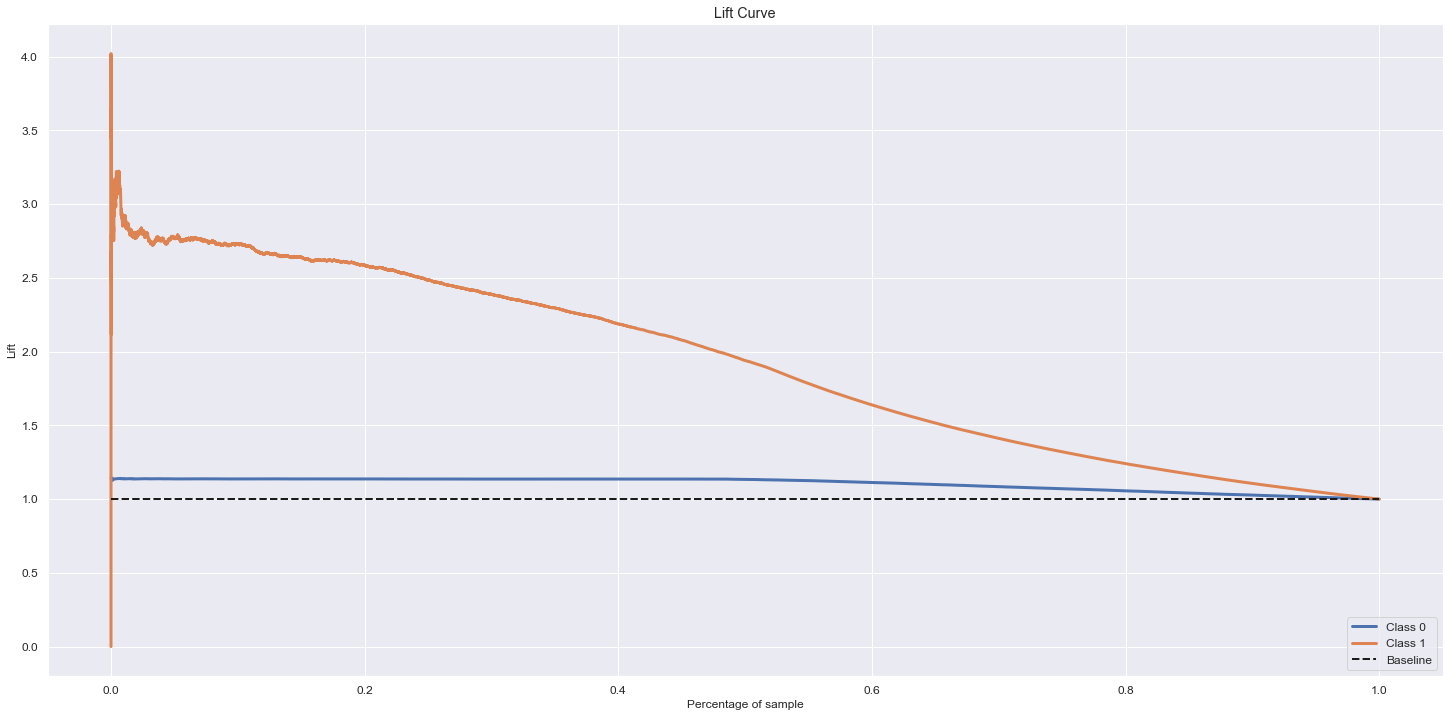

In [99]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_et);

## 6.4 Random Forest

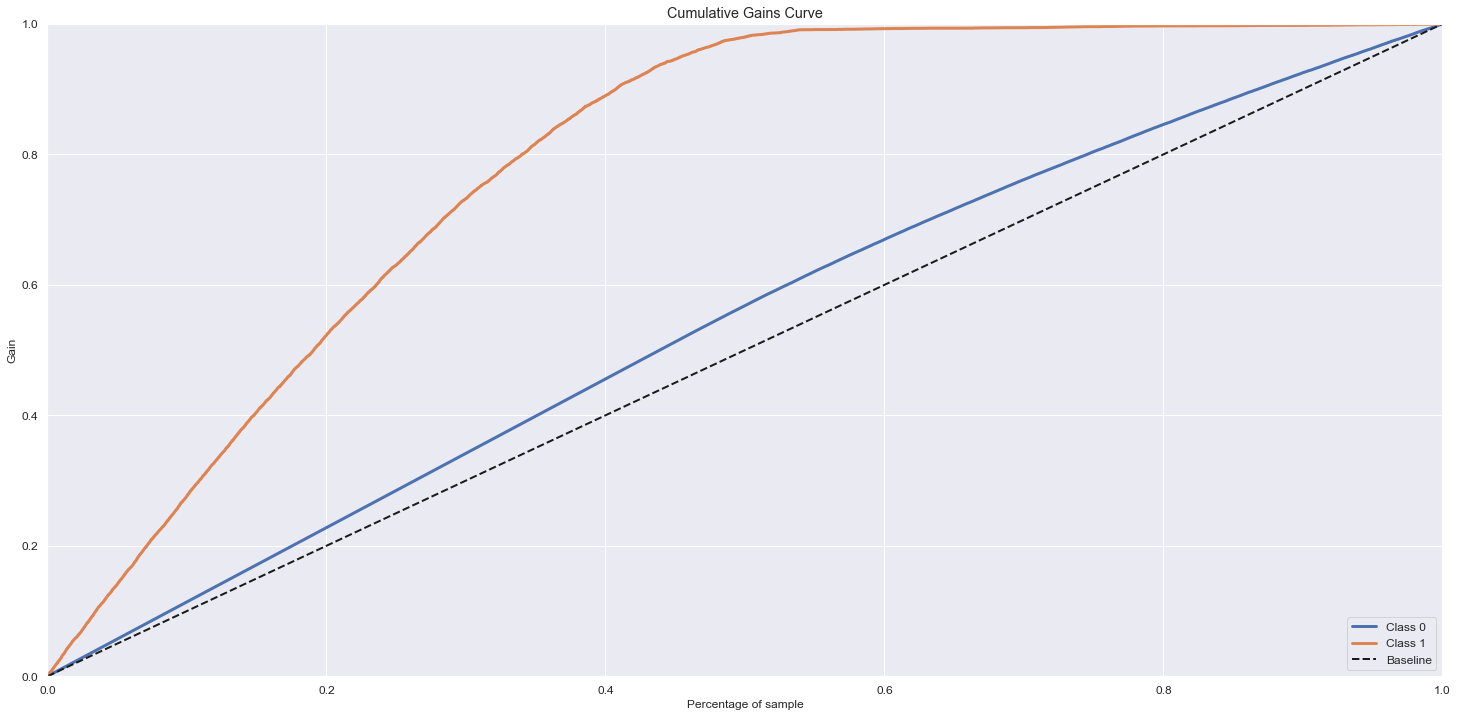

In [101]:
# model definition
rf = en.RandomForestClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)

# model training
rf.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_rf = rf.predict_proba(x_val)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_rf);

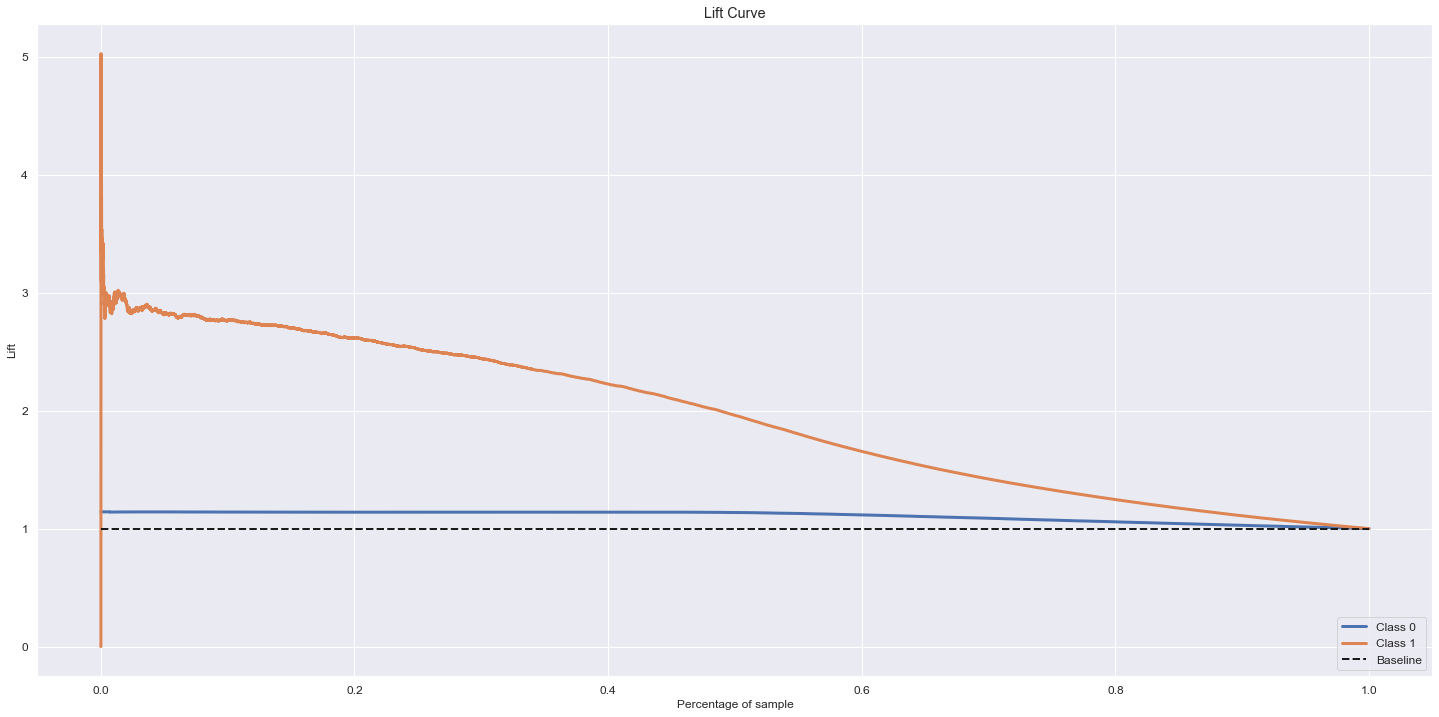

In [102]:
 # Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_rf);

# 7. Model Performance 

## 7.1. Holdout Validation


In [115]:
# copy data
df_perf = x_validation.copy()
df_perf['response'] = y_validation.copy()

# propensity score - from KNN Model
# yhat = Prediction probabilities for each class returned by a classifier.

df_perf['score_knn'] = yhat_knn[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# yhat is an array resulted from predict_proba methods. This result shows class probabilities which classes in lexicographical order
# source: https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09b/sklearn/neighbors/_classification.py#L240
# In this specific case, the class on position '1' is the response '1'.

# propensity score - from Linear Regression Model
df_perf['score_lr'] = yhat_lr[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# propensity score - from Extra Trees Model
df_perf['score_et'] = yhat_et[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# propensity score - from Random Forest Model
df_perf['score_rf'] = yhat_rf[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# models to evaluate
scores = ['score_knn', 'score_lr', 'score_et', 'score_rf']

# create list to store performance metrics
performance = []

k = 0.4 # sample percentage

for i in scores:
    # compute Precision at k (Precision Top K) = ratio of True Positives within all Positives?
    precision = precision_at_k(df_perf, i, k)

    # compute Recall at k = ratio of True Positives within all instances of the dataset
    recall = recall_at_k(df_perf, i, k)

    # save performance metrics
    performance.append([i, precision, recall, k])

# convert performance metrics list to dataframe
df_perf_rank = pd.DataFrame(performance, columns = ['model', 'precision', 'recall', 'k%'])
df_perf_rank['k%'] = df_perf_rank['k%'] * 100
df_perf_rank = df_perf_rank.round(decimals = {'precision' : 4, 'recall' : 4 , 'k%' : 0}).sort_values('recall', ascending = False).reset_index(drop=True)

In [116]:
df_perf_rank 

,model,precision,recall,k%
0,score_rf,0.2768,0.8904,40.0
1,score_et,0.2724,0.8762,40.0
2,score_lr,0.2714,0.8729,40.0
3,score_knn,0.2662,0.8564,40.0


## 7.2 K-Fold Cross Validation

In [117]:
# copy data
X = x_val.copy()
y = y_validation.copy()

# merge data - to unify x_train and x_val (datasets with selected columns from feature selection)
X = X.append(x_train.copy(), ignore_index = True)
y = y.append(y_train.copy(), ignore_index = True)

In [118]:
# models definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)
lr_model = lm.LogisticRegression(random_state = 42)
rf = en.RandomForestClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)

# models dict
models = {
    'score_knn': knn_model,
    'score_lr': lr_model,
    'score_rf': rf,
    'score_et': et
}

# K-Fold number
kfolds = 5
kf = ms.KFold(n_splits = kfolds)

# Precision & Recall at k (in percentage of dataset):
k = 0.4

# Store Precision and Recall at k for all models
perf_metrics = []

# loop through every ML model (i = keys = model name | model = model definition)
for i, model in models.items(): 
    
    performance = []

    for train, test in kf.split(X, y): # returns an array of train and test indexes

        # model training
        model.fit(X.iloc[train], y.iloc[train])

        # model prediction - Generalizing Power
        yhat = model.predict_proba(X.iloc[test])

        # test dataset
        df_perf = X.iloc[test].copy()
        df_perf['response'] = y.iloc[test].copy()

        # propensity score
        df_perf[i] = yhat[:,1].tolist() # get all propensity score values of response = 1 then converts to list

        # compute Precision at k (Precision Top K) = ratio of True Positives within all Positives?
        precision = precision_at_k(df_perf, i, k)

        # compute Recall at k = ratio of True Positives within all instances of the dataset
        recall = recall_at_k(df_perf, i, k)

        # save performance metrics
        performance.append([i, precision, recall, k])


    # After cross-validation of ONE model, compute mean and std. Then store the results:

    # convert performance metrics from ONE model to dataframe
    rank = pd.DataFrame(performance, columns = ['model', 'precision', 'recall', 'k%'])
    rank['k%'] = rank['k%'] * 100

    # perf_metrics = [] # this should be outside models LOOP
    precision_mean = round(rank['precision'].mean(), 4)
    precision_std = round(rank['precision'].std(), 4)
    recall_mean = round(rank['recall'].mean(), 4)
    recall_std = round(rank['recall'].std(), 4)
    perf_metrics.append([i, kfolds, k, precision_mean, precision_std, recall_mean, recall_std])


# this should be outside models LOOP:
perf_metrics_df = pd.DataFrame(perf_metrics, columns = ['model', 'k_folds', 'k', 'precision_at_k_mean', 'precision_at_k_std', 'recall_at_k_mean', 'recall_at_k_std'])
perf_metrics_df 

,model,k_folds,k,precision_at_k_mean,precision_at_k_std,recall_at_k_mean,recall_at_k_std
0,score_knn,5,0.4,0.2632,0.0024,0.8574,0.0021
1,score_lr,5,0.4,0.2679,0.0027,0.8729,0.0036
2,score_rf,5,0.4,0.2740,0.0023,0.8926,0.0030
3,score_et,5,0.4,0.2700,0.0023,0.8798,0.0046


In [119]:
perf_metrics_df.sort_values('recall_at_k_mean', ascending = False) 

,model,k_folds,k,precision_at_k_mean,precision_at_k_std,recall_at_k_mean,recall_at_k_std
2,score_rf,5,0.4,0.2740,0.0023,0.8926,0.0030
3,score_et,5,0.4,0.2700,0.0023,0.8798,0.0046
1,score_lr,5,0.4,0.2679,0.0027,0.8729,0.0036
0,score_knn,5,0.4,0.2632,0.0024,0.8574,0.0021


# 8. Saving Models

In [127]:
folder = '/datas'

# I choose the Random Forest model because of its Average Recall performance measured in the cross-validation
save_model(folder, 'model_random_forest.pkl', rf)

# 9. Model Performance

In [128]:
df11 = x_validation.copy()
df11['response'] = y_validation.copy()

In [129]:
 # Create score column base on probabilites calculated to response equal to 1
df11['score'] = yhat_lr[:, 1].tolist()

In [130]:
df11 = df11.sort_values('score', ascending=False) 

In [131]:
df11.head() 

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,score
354944,172258,0.138347,0.307692,0.185944,0.025806,1,0.0,1,0,26.715134,0.993080,1,0.349375
105015,75825,0.138347,0.092308,0.185944,0.028218,1,0.0,1,0,12.233828,0.955017,1,0.341776
30387,242470,0.103597,0.446154,0.185944,0.025806,1,0.0,1,0,21.664070,0.719723,0,0.339565
324528,307167,0.103597,0.030769,0.185944,0.001243,1,0.0,1,0,2.518037,0.010381,0,0.338676
247663,73825,0.138347,0.015385,0.185944,0.001618,1,0.0,1,0,1.401449,0.695502,0,0.338151


In [139]:
perf_metrics_df.sort_values('recall_at_k_mean', ascending = False) 

,model,k_folds,k,precision_at_k_mean,precision_at_k_std,recall_at_k_mean,recall_at_k_std
2,score_rf,5,0.4,0.2740,0.0023,0.8926,0.0030
3,score_et,5,0.4,0.2700,0.0023,0.8798,0.0046
1,score_lr,5,0.4,0.2679,0.0027,0.8729,0.0036
0,score_knn,5,0.4,0.2632,0.0024,0.8574,0.0021


# 10. Business Performance


In [141]:
df12 = df11.copy() 

## 1. Principais insights sobre os atributos mais relevantes dos clientes interessados ​​em adquirir um seguro auto.

- Clientes com carros novos são mais propensos a fazer seguro.
- 58% das respostas positivas têm entre 33 e 52 anos
- 76% dos clientes que tiveram carros danificados responderam positivamente.
- Os homens representam as respostas mais positivas.

## 2. Qual a porcentagem de clientes interessados ​​em adquirir um seguro de automóvel que a equipe de vendas poderá contatar fazendo 20.000 ligações?


In [144]:
_ = round(df12['response'][:20_000].sum() / df12['response'].sum() * 100)
print(f'Com 20.000 ligações a equipe de vendas entrará em contato {_}% de clientes interessados')

Com 20.000 ligações a equipe de vendas entrará em contato 67% de clientes interessados


## 3. Se a capacidade da equipe de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados ​​em adquirir um seguro de automóvel que a equipe de vendas poderá contatar?


In [145]:
_ = round(df12['response'][:40_000].sum() / df12['response'].sum() * 100)
print(f'Com 40.000 ligações a equipe de vendas entrará em contato {_}% de clientes interessados')

Com 40.000 ligações a equipe de vendas entrará em contato 100% de clientes interessados


## 4. Quantas ligações a equipe de vendas precisa fazer para entrar em contato com 80% dos clientes interessados ​​em adquirir um seguro auto?


In [154]:
_ = round(df12['response'][:24800].sum() / df12['response'].sum() * 100)
print(f'Com 24800 ligações a equipe de vendas entrará em contato com {_}% dos clientes interessados')

Com 24800 ligações a equipe de vendas entrará em contato com 80% dos clientes interessados
